In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import zlib, base64
from skimage.io import imread
import cv2 as cv
import os
import re
import torch
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.utils import draw_segmentation_masks
import skimage
from skimage import io

import itertools

In [40]:
# root = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/'
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/"
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_SunEdison_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LBNL_Mono_Cells/"


img_folder = root + 'img/original/'
mask_folder = root + 'ann_json/'

In [42]:
image_file_extension = "jpg"
# image_file_extension = "tiff"

In [35]:
# non_cell_label_name = "non-cell area"
non_cell_label_name = "non-cell"

In [36]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: non_cell_label_name}

In [12]:
def load_mask(mask_path, image):

    # Creating an array of zeros for each feature type. There may be
    # multiple separate objects of the same feature type, and this
    # is how we store objects of the same feature class together.

    category_dict = {
        "dark": np.zeros(image.shape[:-1]).astype(bool),
        "busbar": np.zeros(image.shape[:-1]).astype(bool),
        "crack": np.zeros(image.shape[:-1]).astype(bool),
        non_cell_label_name: np.zeros(image.shape[:-1]).astype(bool),
    }
    categories_list = ["dark", "busbar", "crack", non_cell_label_name]

    with open(mask_path, "r") as file:
        data = json.load(file)

    try:
        objects = data["objects"]
    except KeyError:
        objects = data["annotation"]["objects"]

    for obj in objects:
        if obj["shape"] == "bitmap":
            code = obj["bitmap"]["data"]
            origin = obj["bitmap"]["origin"]

            z = zlib.decompress(base64.b64decode(code))
            n = np.frombuffer(z, np.uint8)
            mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)

            # This is some unfortunate maneuvering to address the fact that
            # bitmap annotations do not usually come in the same size as the
            # image from which they were labeled, and so it is necessary to
            # situate the annotation in an otherwise empty array that is the
            # same size as the image

            mask_center = np.array([mask.shape[1] / 2, mask.shape[0] / 2])
            mask_center += origin
            up = np.zeros((origin[1], mask.shape[1]))
            mask2 = np.vstack((up, mask))
            left = np.zeros((mask2.shape[0], origin[0]))
            mask3 = np.hstack((left, mask2))
            down = np.zeros((image.shape[0] - mask3.shape[0], mask3.shape[1]))
            mask4 = np.vstack((mask3, down))
            right = np.zeros((mask4.shape[0], image.shape[1] - mask4.shape[1]))
            mask5 = np.hstack((mask4, right)).astype(bool)
            
        elif obj["shape"] == "rectangle":
            # Handle rectangle masks
            points = obj["points"]["exterior"]
            x1, y1 = points[0]
            x2, y2 = points[1]
            
            # Ensure correct order of coordinates
            #* commented out bc unsure if needed rn
            # x_min, x_max = min(x1, x2), max(x1, x2)
            # y_min, y_max = min(y1, y2), max(y1, y2)
            
            mask5 = np.zeros(image.shape[:-1]).astype(bool)
            mask5[y1:y2, x1:x2] = True            

        # Save the data from each object in the appropriate array depending on
        # its feature type
        for category in categories_list:
            if category in obj["classTitle"].lower():
                category_dict[category] = np.logical_or(
                    category_dict[category], mask5
                ).astype(bool)

    return category_dict


def stack_masks(
    category_dict, order=[3, 2, 1, 0], mapping={0: 1, 1: 2, 2: 3, 3: 4}
):

    # Stack the four n_x by n_y feature arrays
    all_masks = torch.dstack([torch.tensor(v) for v in category_dict.values()]).permute(
        2, 0, 1
    )

    new_tensor = torch.zeros(
        [all_masks.shape[1], all_masks.shape[2]], dtype=torch.float64
    )

    for i, j in itertools.product(range(image.shape[0]), range(image.shape[1])):

        if all_masks[order[0], i, j]:
            val = mapping[order[0]]
        elif all_masks[order[1], i, j]:
            val = mapping[order[1]]
        elif all_masks[order[2], i, j]:
            val = mapping[order[2]]
        elif all_masks[order[3], i, j]:
            val = mapping[order[3]]
        else:
            val = 0

        new_tensor[i, j] = val

    return new_tensor

In [43]:
files = [c for c in os.listdir(mask_folder)]

regex_string = r'(.+)\.' + image_file_extension + r'\.json'

n_masks = [re.search(regex_string, f).group(1) for f in files]

In [13]:
def plot_and_show_labels(cracks_mask, order=[3, 2, 1, 0]):
    fig, ax = plt.subplots()

    clim = (0, 4)
    ax.imshow(cracks_mask, clim=clim, interpolation='None')

    # Do legend
    cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]
    handles, labels = ax.get_legend_handles_labels()
    
    for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
            patch = mpatches.Patch(color=c, label=classlabel, ec='k')
            handles.append(patch)
    ax.legend(handles=handles, fontsize='x-small')

    ax.axis('off')

/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_SunEdison_Mono/ann_json/SW3-DH3000-1000h-PT-cell18-r180.jpg.json


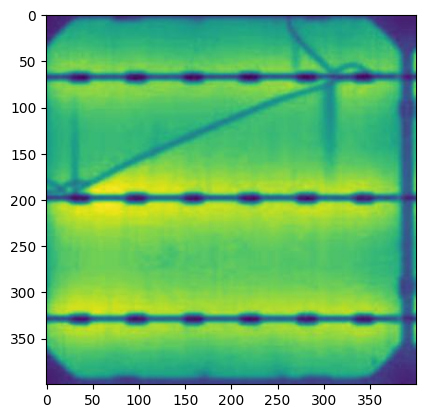

In [44]:
n = n_masks[1]
mask_path = os.path.join(mask_folder, f'{n}.{image_file_extension}.json')
img_path = os.path.join(img_folder, f'{n}.{image_file_extension}')
image = imread(img_path)
print(mask_path)
category_dict = load_mask(mask_path, image)
plt.imshow(image)

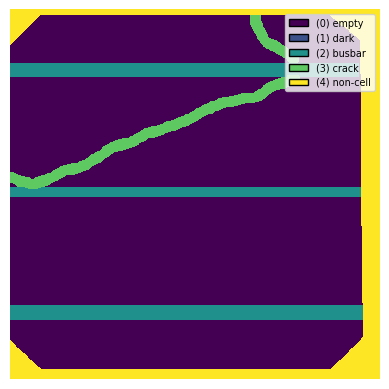

In [45]:
default_mask = stack_masks(category_dict)

plot_and_show_labels(default_mask)

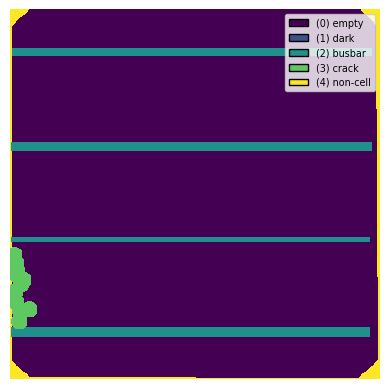

In [155]:
cracks_mask = stack_masks(category_dict, order=[2, 0, 1, 3])

plot_and_show_labels(cracks_mask)

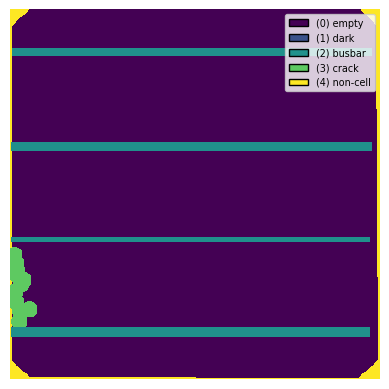

In [156]:
busbar_mask = stack_masks(category_dict, order=[1, 0, 2, 3])

plot_and_show_labels(busbar_mask)

In [159]:
# i = 0
# total = len(n_masks)
# for n in n_masks:
#     i += 1
#     mask_path = os.path.join(mask_folder, f'{n}.{image_file_extension}.json')
#     img_path = os.path.join(img_folder, f'{n}.{image_file_extension}')
#     try:
#         image = imread(img_path)
#         category_dict = load_mask(mask_path, image)
#         save_dir_busbars = os.path.join(root, 'ann_npy_split_busbars', 'original', f'{n}.npy')
#         save_dir_cracks = os.path.join(root, 'ann_npy_split_cracks', 'original', f'{n}.npy')
        
#         busbars_mask = stack_masks(category_dict, order=[1, 0, 2, 3])
#         cracks_mask = stack_masks(category_dict, order=[2, 0, 1, 3])
        
#         np.save(save_dir_busbars, busbars_mask)
#         np.save(save_dir_cracks, cracks_mask)
        
#         print(f"Saved ({i} / {total}): {n}")
#     except Exception as e:
#         print(n)
#         print(e)
#         continue

Saved (1 / 123): sa19978_sub_EL_9-c04
Saved (2 / 123): sa19986_sub_EL_9-c02
Saved (3 / 123): sa19974_sub_EL_9-c03
Saved (4 / 123): sa19972_sub_EL_9-c04
Saved (5 / 123): sa19982_sub_EL_9-c04
Saved (6 / 123): sa19997_sub_EL_9-c01
Saved (7 / 123): sa19984_sub_EL_9-c03
Saved (8 / 123): sa19976_sub_EL_9-c02
Saved (9 / 123): sa19988_sub_EL_9-c04
Saved (10 / 123): sa19979_sub_EL_9-c03
Saved (11 / 123): sa19973_sub_EL_9-c03
Saved (12 / 123): sa19960_sub_EL_9-c01
Saved (13 / 123): sa19985_sub_EL_9-c04
Saved (14 / 123): sa19990_sub_EL_9-c01
Saved (15 / 123): sa19983_sub_EL_9-c03
Saved (16 / 123): sa19971_sub_EL_9-c02
Saved (17 / 123): sa19989_sub_EL_9-c03
Saved (18 / 123): sa19976_sub_EL_9-c04
Saved (19 / 123): sa19963_sub_EL_9-c01
Saved (20 / 123): sa19988_sub_EL_9-c02
Saved (21 / 123): sa19969_sub_EL_9-c01
Saved (22 / 123): sa19978_sub_EL_9-c02
Saved (23 / 123): sa19958_sub_EL_9-c01
Saved (24 / 123): sa19993_sub_EL_9-c01
Saved (25 / 123): sa19980_sub_EL_9-c03
Saved (26 / 123): sa19972_sub_EL_9